# Part 6: AdaBoostClassifier Model

### Import Libraries

In [3]:
import warnings
warnings.filterwarnings('ignore')

import pandas as pd
import numpy as np
import missingno as msno
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats 

from sklearn.ensemble import AdaBoostClassifier

from sklearn.metrics import f1_score,accuracy_score, precision_score, recall_score, roc_curve, roc_auc_score, precision_recall_curve, auc
from sklearn import metrics
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import plot_precision_recall_curve
from sklearn.metrics import average_precision_score, confusion_matrix
import matplotlib.pyplot as plt

## Load Dataset
Please see the link to know more about the dataset: https://archive.ics.uci.edu/ml/datasets/Breast+Cancer+Wisconsin+%28Diagnostic%29

Attribute Information:

- 1) ID number
- 2) Diagnosis (M = malignant, B = benign)

Ten real-valued features are computed for each cell nucleus:

- a) radius (mean of distances from center to points on the perimeter)
- b) texture (standard deviation of gray-scale values)
- c) perimeter
- d) area
- e) smoothness (local variation in radius lengths)
- f) compactness (perimeter^2 / area - 1.0)
- g) concavity (severity of concave portions of the contour)
- h) concave points (number of concave portions of the contour)
- i) symmetry
- j) fractal dimension ("coastline approximation" - 1)

In [4]:
features = ['area_worst',
 'concave points_worst',
 'concave points_mean',
 'perimeter_worst',
 'concavity_mean',
 'radius_worst',
 'radius_mean',
 'perimeter_mean',
 'area_se',
 'area_mean',
 'concavity_worst',
 'compactness_worst',
 'texture_worst',
 'smoothness_worst',
 'radius_se', 'diagnosis']

df = pd.read_csv('preprocessed_breast_cancer.csv', usecols = features)
df.head()

,diagnosis,radius_mean,perimeter_mean,area_mean,concavity_mean,concave points_mean,radius_se,area_se,radius_worst,texture_worst,perimeter_worst,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave points_worst
0,1,17.99,122.80,1001.0,0.3001,0.14710,1.0950,153.40,25.38,17.33,184.60,2019.0,0.1622,0.6656,0.7119,0.2654
1,1,20.57,132.90,1326.0,0.0869,0.07017,0.5435,74.08,24.99,23.41,158.80,1956.0,0.1238,0.1866,0.2416,0.1860
2,1,19.69,130.00,1203.0,0.1974,0.12790,0.7456,94.03,23.57,25.53,152.50,1709.0,0.1444,0.4245,0.4504,0.2430
3,1,11.42,77.58,386.1,0.2414,0.10520,0.4956,27.23,14.91,26.50,98.87,567.7,0.2098,0.8663,0.6869,0.2575
4,1,20.29,135.10,1297.0,0.1980,0.10430,0.7572,94.44,22.54,16.67,152.20,1575.0,0.1374,0.2050,0.4000,0.1625


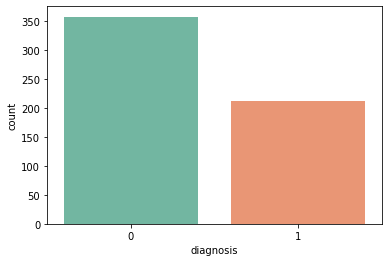

In [5]:
sns.countplot(df['diagnosis'], palette = 'Set2')

### Split Input and Traget Variables

In [6]:
X = df.drop('diagnosis', axis = 1) 
y = df['diagnosis']

In [7]:
X.columns

Index(['radius_mean', 'perimeter_mean', 'area_mean', 'concavity_mean',
       'concave points_mean', 'radius_se', 'area_se', 'radius_worst',
       'texture_worst', 'perimeter_worst', 'area_worst', 'smoothness_worst',
       'compactness_worst', 'concavity_worst', 'concave points_worst'],
      dtype='object')

### Train Test Split

In [8]:
# train_test_split is used to split the dataset into test set and train set
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state =0)

print("Original shape of dataset: {}".format(df.shape))         # shape of original dataset
print("Shape of training dataset: {}".format(X_train.shape))      # shape of training dataset after split
print("Shape of testing dataset: {}".format(X_test.shape))        # shape of testing dataset after split

Original shape of dataset: (569, 16)
Shape of training dataset: (426, 15)
Shape of testing dataset: (143, 15)


## Feature Scaling

In [9]:
from sklearn.preprocessing import StandardScaler
sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)

## Defining all the functions

#### Writing a function that returns the evaluation metrics as a DataFrame

In [10]:
def model_comparison(models =[], model_names= []):
    
    acc = []
    prec = []
    recal = []
    f1_train = []
    f1_test = []
    roc_auc = []
    pr_auc = []
    
    for model in range(len(models)):
        clf = models[model]
        clf.fit(X_train, y_train)
        y_hat = clf.predict(X_test)
        y_hat_train = clf.predict(X_train) 
        pred_prob = clf.predict_proba(X_test)
        precision, recall, _ = precision_recall_curve(y_test, pred_prob[:, 1], pos_label=1)

        
        f1_train.append(f1_score(y_hat_train, y_train))
        f1_test.append(f1_score(y_hat, y_test))
        acc.append(accuracy_score(y_hat, y_test))
        prec.append(precision_score(y_hat, y_test))
        recal.append(recall_score(y_hat, y_test))
        roc_auc.append(roc_auc_score(y_test, y_hat))
        pr_auc.append(auc(recall, precision))
        
    compare = pd.DataFrame({'Algorithm' : model_names , 'ROC_AUC': roc_auc, 'PR_AUC': pr_auc, 'Precision': prec, 'Recall': recal, 'F1_Train': f1_train, 'F1_Test': f1_test, 'Accuracy' : acc, })
    return compare

#### Writing a function returns Macro and Weighted average of Recall Score

In [11]:
def macro_weighted(y_test, y_hat):
    
    rec = metrics.recall_score(y_test, y_hat)
    print ("Recall Score:", rec)

    rec_mac = metrics.recall_score(y_test, y_hat, average = 'macro')
    print ("Macro Average of Recall Score:", rec_mac)

    rec_wei = metrics.recall_score(y_test, y_hat, average = 'weighted')
    print ("Weighted Average of Recall Score:", rec_wei)

#### Detailed Macro & Weighted average values of the performance metrics

In [12]:
def macro_weighted_prec_rec(y_test, y_hat):
    
    rec = metrics.recall_score(y_test, y_hat)
    print ("Recall Score:", rec)
    
    rec_mac = metrics.recall_score(y_test, y_hat, average = 'macro')
    print ("Macro Average of Recall Score:", rec_mac)

    rec_wei = metrics.recall_score(y_test, y_hat, average = 'weighted')
    print ("Weighted Average of Recall Score:", rec_wei)
    
    print ('.')
    
    prec_mac = metrics.precision_score(y_test, y_hat, average = 'macro')
    print ("Macro Average of Precision Score:", prec_mac)

    prec_wei = metrics.precision_score(y_test, y_hat, average = 'weighted')
    print ("Weighted Average of Precision Score:", prec_wei)

    f1_mac = metrics.f1_score(y_test, y_hat, average = 'macro')
    print ("Macro Average of F1 Score:", f1_mac)

    f1_wei = metrics.f1_score(y_test, y_hat, average = 'weighted')
    print ("Weighted Average of F1 Score:", f1_wei)

#### Performance of the Tarining & Test Set

In [13]:
def f1_acc(y_test, y_hat, y_train, y_hat_train): 
    
    acc_train = metrics.accuracy_score(y_train, y_hat_train)
    print ("Accuracy Score of Train Set:", acc_train)
    
    acc_test = metrics.accuracy_score(y_test, y_hat)
    print ("Accuracy Score of Test Set:", acc_test)
    
    print ('.')
    
    f1_train = metrics.f1_score(y_train, y_hat_train, average = 'macro')
    print ("F1 Score of Train Set:", f1_train)
    
    f1_test = metrics.f1_score(y_test, y_hat, average = 'macro')
    print ("F1 Score of Test Set:", f1_test)
    
    ax1 = sns.distplot(y_train, hist=False, color='pink')
    sns.distplot(y_hat_train, hist=False, ax=ax1, color='lightblue')
    
    plt.title('Actual vs Predicted Values for Diagnosis (Training Set)')
    plt.xlabel('Diagnosis')
    plt.ylabel('Proportion of Results')
    plt.show()
    
    ax2 = sns.distplot(y_test, hist=False, color='salmon')
    sns.distplot(y_hat, hist=False, ax=ax2, color='lightblue')
    plt.title('Actual vs Predicted Values for Diagnosis (Test Set)')
    plt.xlabel('Diagnosis')
    plt.ylabel('Proportion of Results')
    plt.show()

#### ROC_AUC, Precision Recall AUC and the Confusion Matrices

In [14]:
def roc_pr_cm(models=[]):
    
    roc_auc = []
    pr_auc = []

    for model in range(len(models)):
        clf = models[model]
        clf.fit(X_train, y_train)
        y_hat = clf.predict(X_test)
        y_hat_train = clf.predict(X_train) 
    
        # predict probabilities
        pred_prob = clf.predict_proba(X_test)
    
        # Print the confusion matrix
        print('---------------------------------------------------------------')
        
        data = confusion_matrix(y_test, y_hat)
        df_cm = pd.DataFrame(data, columns=np.unique(y_test), index = np.unique(y_test))
        df_cm.index.name = 'Actual'
        df_cm.columns.name = 'Predicted'
        plt.figure(figsize = (6, 4))
        #sns.set(font_scale=1.4) #for label size
        sns.heatmap(df_cm, cmap="Blues", annot=True,annot_kws={"size": 12})# font size
        plt.show()
        
        tn, fp, fn, tp = confusion_matrix(y_test, y_hat).ravel()
        print ("TP: {}, FP: {}, TN: {}, FN: {}".format(tp, fp, tn, fn))

        # Print the precision and recall, among other metrics
        print('---------------------------------------------------------------')
        print(metrics.classification_report(y_test, y_hat, digits=3))
        
        print('---------------------------------------------------------------')
        
        macro_weighted(y_test, y_hat)
        
        print('---------------------------------------------------------------')
     
        fpr, tpr, thresh = roc_curve(y_test, pred_prob[:, 1], pos_label=1)
        roc_auc.append(roc_auc_score(y_test, y_hat))
    
        plt.style.use('seaborn')
        plt.figure(figsize=(8, 4))
        # plot roc curves
        plt.plot(fpr, tpr, label = models[model])
    
        plt.title('ROC curve where AUC= {}'.format(roc_auc[model]))
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive rate')

        plt.legend(loc='best')
        plt.savefig('ROC', dpi=300)
        plt.show();
    
        # calculate model precision-recall curve
        # precision, recall, _ = precision_recall_curve(y_hat , y_test)
        precision, recall, _ = precision_recall_curve(y_test, pred_prob[:, 1], pos_label=1)
        pr_auc.append(auc(recall, precision))
    
        # plot the model precision-recall curve
        plt.style.use('seaborn')
        plt.figure(figsize=(8, 4))
        plt.plot(recall, precision, marker='.', label = models[model])
        plt.title('Precision Recall curve AUC= {}'.format(pr_auc[model]))
        plt.xlabel('Recall')
        plt.ylabel('Precision')
        plt.legend(loc='best')
        plt.show()

## Final Model

In [15]:
models = [AdaBoostClassifier(random_state = 42)]
model_names=['AdaBoostClassifier']
model_comparison(models, model_names)

,Algorithm,ROC_AUC,PR_AUC,Precision,Recall,F1_Train,F1_Test,Accuracy
0,AdaBoostClassifier,0.98501,0.994428,0.981132,0.981132,1.0,0.981132,0.986014


---------------------------------------------------------------


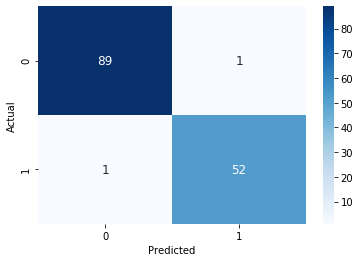

TP: 52, FP: 1, TN: 89, FN: 1
---------------------------------------------------------------
              precision    recall  f1-score   support

           0      0.989     0.989     0.989        90
           1      0.981     0.981     0.981        53

    accuracy                          0.986       143
   macro avg      0.985     0.985     0.985       143
weighted avg      0.986     0.986     0.986       143

---------------------------------------------------------------
Recall Score: 0.9811320754716981
Macro Average of Recall Score: 0.9850104821802935
Weighted Average of Recall Score: 0.986013986013986
---------------------------------------------------------------


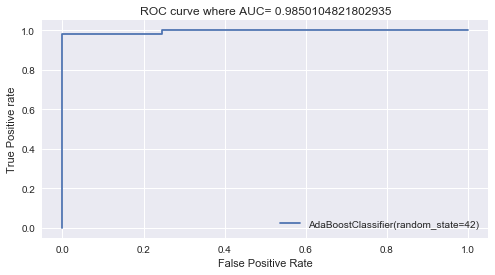

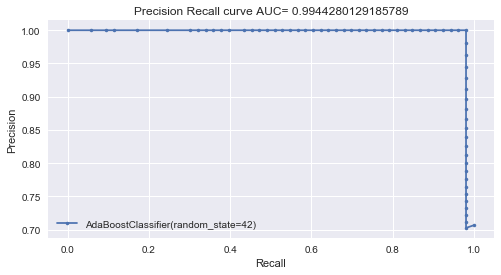

In [16]:
models = [AdaBoostClassifier(random_state = 42)]
roc_pr_cm(models)

Recall Score: 0.9811320754716981
Macro Average of Recall Score: 0.9850104821802935
Weighted Average of Recall Score: 0.986013986013986
.
Macro Average of Precision Score: 0.9850104821802935
Weighted Average of Precision Score: 0.986013986013986
Macro Average of F1 Score: 0.9850104821802935
Weighted Average of F1 Score: 0.986013986013986
Accuracy Score of Train Set: 1.0
Accuracy Score of Test Set: 0.986013986013986
.
F1 Score of Train Set: 1.0
F1 Score of Test Set: 0.9850104821802935


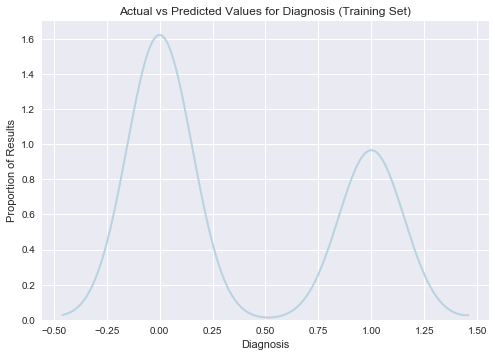

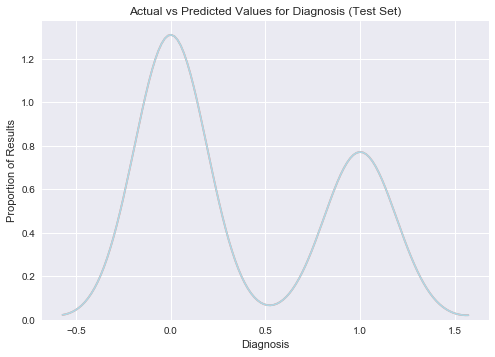

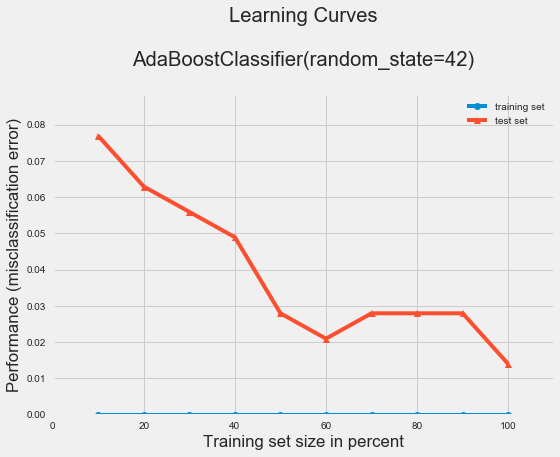

In [17]:
from sklearn import model_selection
from pprint import pprint

ada = AdaBoostClassifier(random_state = 42)

ada.fit(X_train, y_train)
y_hat = ada.predict(X_test)
y_hat_train = ada.predict(X_train)

macro_weighted_prec_rec(y_test, y_hat)

f1_acc(y_test, y_hat, y_train, y_hat_train)

from mlxtend.plotting import plot_learning_curves
plot_learning_curves(X_train, y_train, X_test, y_test, ada)
plt.show()

### Let's fit the whole data now Predict result from user input.

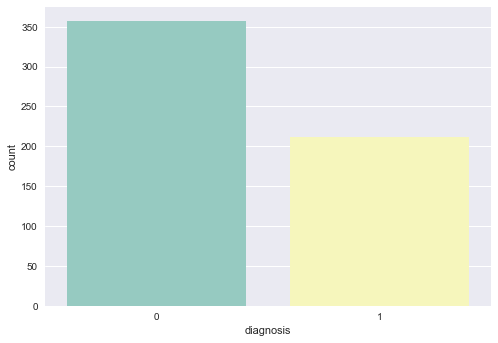

In [18]:
features = ['area_worst',
 'concave points_worst',
 'concave points_mean',
 'perimeter_worst',
 'concavity_mean',
 'radius_worst',
 'radius_mean',
 'perimeter_mean',
 'area_se',
 'area_mean',
 'concavity_worst',
 'compactness_worst',
 'texture_worst',
 'smoothness_worst',
 'radius_se', 'diagnosis']

df = pd.read_csv('preprocessed_breast_cancer.csv', usecols = features)

X = df.drop('diagnosis', axis = 1) 
y = df['diagnosis']

sns.countplot(df['diagnosis'], palette = 'Set3')

In [19]:
from sklearn.preprocessing import StandardScaler
sc = StandardScaler()
X_std = sc.fit_transform(X)

In [20]:
ada = AdaBoostClassifier(random_state = 42)
ada.fit(X, y)

AdaBoostClassifier(random_state=42)

In [22]:
import pickle 
# open a file, where you ant to store the data
file = open('ada_breastcancer.pkl', 'wb')

# dump information to that file
pickle.dump(ada, file)